In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import requests
import os

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Data Modelling 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "10g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)

24/10/04 12:14:46 WARN Utils: Your hostname, codespaces-c6855a resolves to a loopback address: 127.0.0.1; using 10.0.0.100 instead (on interface eth0)
24/10/04 12:14:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/04 12:14:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/04 12:14:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/04 12:14:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/10/04 12:14:47 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/10/04 12:14:47 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


## Read dataset

In [3]:
# Information on merchants
merchant = spark.read.parquet("../data/curated/part_1/clean_merchant.parquet")

# Information on merchant's fraud probability
merchant_fraud_prob = pd.read_csv("../data/tables/part_1/merchant_fraud_probability.csv")

### Preprocessing `goods` feature

In [4]:
from pyspark.ml.feature import CountVectorizer, PCA, StopWordsRemover
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import monotonically_increasing_id

In [5]:
goods = merchant.select("goods")

In [6]:
clean_goods = goods.withColumn("str_goods", lower(regexp_replace("goods", "[^\w\s]", "")))

tokenizer = Tokenizer(inputCol="str_goods", outputCol="tokens")
clean_goods = tokenizer.transform(clean_goods)

remover = StopWordsRemover(inputCol="tokens", outputCol="clean_goods")
clean_goods = remover.transform(clean_goods)
clean_goods = clean_goods.select('clean_goods')

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_56651/2771126159.py:1: SyntaxWarning: invalid escape sequence '\w'
  clean_goods = goods.withColumn("str_goods", lower(regexp_replace("goods", "[^\w\s]", "")))


In [7]:
count_vectorizer = CountVectorizer(inputCol="clean_goods", outputCol="features")

model = count_vectorizer.fit(clean_goods)
result = model.transform(clean_goods)

In [8]:
result.limit(4)

clean_goods,features
"[watch, clock, je...","(94,[0,12,13,14,5..."
"[motor, vehicle, ...","(94,[5,71,72,76,7..."
"[cable, satellite...","(94,[4,44,45,46,4..."
"[opticians, optic...","(94,[9,73,74,75],..."


In [9]:
pca = PCA(k=12, inputCol="features")
pca.setOutputCol("pca_features")

model = pca.fit(result)
pca_result = model.transform(result)

24/10/04 12:14:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [10]:
model.transform(result).collect()[0].pca_features

DenseVector([0.7685, -0.6656, 0.3307, -0.7595, -0.0918, -0.2737, 0.9877, 1.0146, 0.314, 0.568, -0.028, -0.0165])

In [11]:
model.explainedVariance.sum()

np.float64(0.7348035599530366)

In [12]:
pca_result = pca_result.withColumn("id", monotonically_increasing_id())
merchant = merchant.withColumn("id", monotonically_increasing_id())

In [13]:
merchant = merchant.join(pca_result.select('pca_features', 'id'), on='id', how='inner')
merchant = merchant.drop("id")

In [14]:
from pyspark.sql.functions import when

In [15]:
# Define the ordered categories
ordered_categories = ['a', 'b', 'c', 'd', 'e']

# Map the categories to their corresponding ordinal codes
merchant = merchant.withColumn(
    "ordinal_revenue_level",
    when(F.col("revenue_level") == "a", 0)
    .when(F.col("revenue_level") == "b", 1)
    .when(F.col("revenue_level") == "c", 2)
    .when(F.col("revenue_level") == "d", 3)
    .when(F.col("revenue_level") == "e", 4)
)

merchant = merchant.drop("revenue_level")

### Join transaction dataset

In [16]:
temp = spark.read.parquet('../data/curated/all_details/')
temp.limit(5)

order_id,user_id,merchant_abn,order_datetime,dollar_value,postcode,merchant_fraud,consumer_fraud,weekly_personal_disposable,median_total_household_income,median_total_family_income,sa2_code,sa2_name,avg_household_size,is_po_box,median_age
360a891b-8271-461...,44,80788167198,2021-08-20,158.88701712957197,5074,0.0,0.0,497.2312731843797,1427.0,1892.0,401041015,Paradise - Newton,2.4,false,40.0
5c77cc43-b0fd-432...,44,37687523474,2021-08-20,14.31708123947184,5074,0.0,0.0,497.2312731843797,1427.0,1892.0,401041015,Paradise - Newton,2.4,false,40.0
e75d90e3-2656-4dc...,44,43186523025,2021-08-19,56.782923459184794,5074,0.0,0.0,497.2312731843797,1427.0,1892.0,401041015,Paradise - Newton,2.4,false,40.0
a9f754e4-af51-463...,44,33233265647,2021-08-15,26.557524640642136,5074,0.0,0.0,497.2312731843797,1427.0,1892.0,401041015,Paradise - Newton,2.4,false,40.0
71753d60-5634-422...,44,70172340121,2021-07-15,139.3475757940659,5074,0.0,0.0,497.2312731843797,1427.0,1892.0,401041015,Paradise - Newton,2.4,false,40.0


In [17]:
full_dataset = temp.join(merchant, on='merchant_abn', how='left')
full_dataset.count()

14195505

In [18]:
# Select useful columns
merchant_is_fraud_model = full_dataset.select(["order_id", "merchant_abn", "user_id", "order_datetime", "dollar_value", "postcode", "merchant_fraud", "weekly_personal_disposable",
                     "median_total_household_income", "median_total_family_income", "avg_household_size", "median_age", "is_po_box", "ordinal_revenue_level" ,"take_rate", "pca_features"])

We check the number of Null values in merchant fraud probability.

In [19]:
merchant_is_fraud_model.filter(F.col('merchant_fraud') > 0).count()

4059

24/10/04 12:15:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [20]:
merchant_is_fraud_model.limit(5)

order_id,merchant_abn,user_id,order_datetime,dollar_value,postcode,merchant_fraud,weekly_personal_disposable,median_total_household_income,median_total_family_income,avg_household_size,median_age,is_po_box,ordinal_revenue_level,take_rate,pca_features
6a84c3cf-612a-457...,15549624934,2,2021-08-20,130.3505283105634,2782,0.0,503.7805889311172,1528.0,1978.0,2.3,50.0,false,2,2.76,[-0.1654801171818...
21c98e87-bba2-4be...,17324645993,4,2021-08-21,4.130908994559449,2780,0.0,465.27811385609044,1238.0,1790.0,2.1,50.0,false,0,5.73,[0.60148507156068...
179efcdd-130a-4a1...,22033359776,1,2021-08-21,461.0552290700037,6935,0.0,NULL,NULL,NULL,NULL,NULL,true,1,3.1,[-0.4748733963535...
b433fc0d-e64c-457...,22059270846,6,2021-08-19,39.724564457957754,2033,0.0,549.9992329236431,2117.0,2743.0,2.3,32.0,false,0,6.59,[-0.1654801171818...
dd1ba445-4ec9-410...,23661821077,6,2021-08-19,3.866733632735169,2033,0.0,549.9992329236431,2117.0,2743.0,2.3,32.0,false,2,3.0,[0.61247727669343...


## Feature selection

We want to check the correlation between each attribute using a subsample dataset. The subsample dataset contains 30% of the 2022 data and 70% of the 2021 data as we will train model on the data in 2021 and test it on the data in 2022.

In [21]:
from pyspark.sql.functions import year
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
sample_merchant_fraud_df = merchant_is_fraud_model.sample(0.01, seed=42).toPandas()

<Axes: >

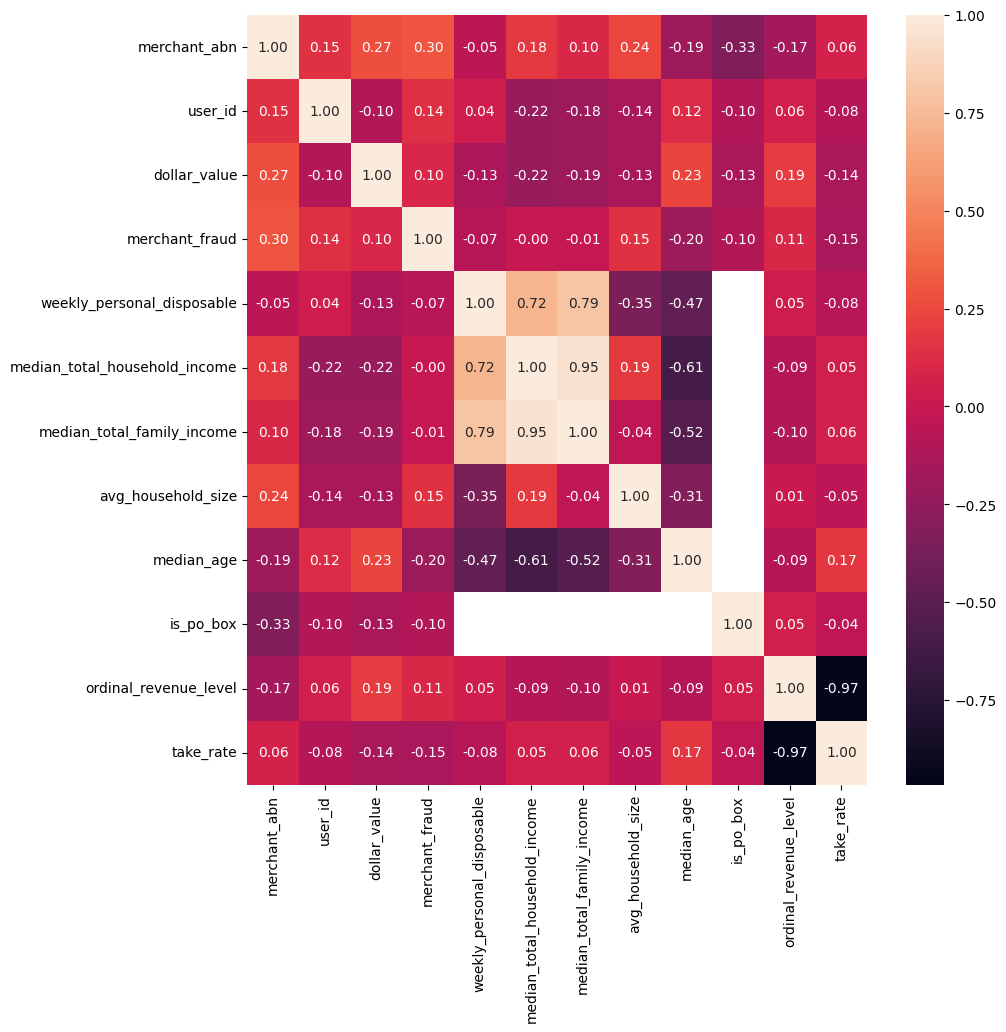

In [23]:
num_cols = [col for col in sample_merchant_fraud_df.columns if sample_merchant_fraud_df[col].dtype != 'object']

plt.figure(figsize=(10, 10))
sns.heatmap(sample_merchant_fraud_df.loc[sample_merchant_fraud_df['merchant_fraud'] > 0][num_cols].corr(), annot=True, fmt='.2f')

Because pyspark ml can't handle Null values, we drop external attributes that contain Null values.

In [24]:
selected_features = ["order_id", "merchant_abn", "dollar_value", "merchant_fraud", "ordinal_revenue_level" ,"take_rate", "order_datetime", "pca_features"]
impute_merchant_fraud_sdf = merchant_is_fraud_model.select(selected_features)
impute_merchant_fraud_sdf.limit(5)

order_id,merchant_abn,dollar_value,merchant_fraud,ordinal_revenue_level,take_rate,order_datetime,pca_features
6a84c3cf-612a-457...,15549624934,130.3505283105634,0.0,2,2.76,2021-08-20,[-0.1654801171818...
21c98e87-bba2-4be...,17324645993,4.130908994559449,0.0,0,5.73,2021-08-21,[0.60148507156068...
179efcdd-130a-4a1...,22033359776,461.0552290700037,0.0,1,3.1,2021-08-21,[-0.4748733963535...
b433fc0d-e64c-457...,22059270846,39.724564457957754,0.0,0,6.59,2021-08-19,[-0.1654801171818...
dd1ba445-4ec9-410...,23661821077,3.866733632735169,0.0,2,3.0,2021-08-19,[0.61247727669343...


In [25]:
impute_merchant_fraud_sdf.count()

14195505

In [26]:
impute_merchant_fraud_sdf.filter(F.col("take_rate").isNotNull()).count()

13614675

As we expected, there are some merchants not existing in transaction dataset, we will remove those instances.

In [27]:
impute_merchant_fraud_sdf = impute_merchant_fraud_sdf.filter(F.col("take_rate").isNotNull())

Let's check the number of instances with non-missing fraud probability.

In [28]:
impute_merchant_fraud_sdf.filter(F.col('merchant_fraud') > 0).count()

4003

We would like to use these instances to build a imputation model for the remaining null values.

In [29]:
model_df = impute_merchant_fraud_sdf.filter(F.col('merchant_fraud') > 0)

In [30]:
final_df = model_df.dropna('any')
final_df.count()

4003

In [31]:
final_df.limit(5)

order_id,merchant_abn,dollar_value,merchant_fraud,ordinal_revenue_level,take_rate,order_datetime,pca_features
77d1acc4-ba19-419...,90568944804,413.3192666455688,28.583030842180733,1,4.1,2021-11-26,[0.60148507156068...
3c48f79d-878c-415...,90568944804,727.1981145606727,30.41342923227757,1,4.1,2021-11-28,[0.60148507156068...
1bb5bcfb-f5c3-453...,90568944804,452.64607014411234,33.172494688960434,1,4.1,2021-11-29,[0.60148507156068...
baf5d781-a1b1-42f...,90568944804,1933.576159333736,30.41342923227757,1,4.1,2021-11-28,[0.60148507156068...
b5ecb989-266b-4bf...,90568944804,682.6519028372896,28.583030842180733,1,4.1,2021-11-26,[0.60148507156068...


In [32]:
# Save data to file
final_df.write.mode('overwrite').parquet('../data/curated/modelling/')

In [33]:
model_sdf = spark.read.parquet('../data/curated/modelling')

## Train Random Forest regression

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [35]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = model_sdf.randomSplit([0.8, 0.2], seed=42)

In [36]:
print(trainingData.count())
print(testData.count())

3260
743


### Baseline Model

The model only predicts the mean value for all test instances.

In [37]:
mean_value = testData.agg(F.mean("merchant_fraud")).collect()[0][0]
mean_predictions_df = testData.select("merchant_fraud").withColumn("prediction", F.lit(mean_value))

mse_evaluator = RegressionEvaluator(labelCol="merchant_fraud", predictionCol="prediction", metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol="merchant_fraud", predictionCol="prediction", metricName="mae")

# Get the score
mse = mse_evaluator.evaluate(mean_predictions_df)
mae = mae_evaluator.evaluate(mean_predictions_df)

print(f"Mean Square Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Square Error: 28.812977419553015
Mean Absolute Error: 2.0507967686080995


### Random Forest

We aim to create a simple model, therefore, the model hyperparameters were chosen arbitrarily.

In [38]:
from pyspark.ml import Pipeline

In [39]:
features = 'features'
input_cols = trainingData.drop('merchant_fraud').drop('order_id').drop('order_datetime').drop('merchant_abn').columns

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

In [40]:
rft = RandomForestRegressor(
    featuresCol='features', 
    labelCol='merchant_fraud',
    numTrees=5, 
    maxDepth=5,
    seed=42
)

In [41]:
pipeline = Pipeline(stages=[assembler, rft])
model = pipeline.fit(trainingData)

- Make predictions.

In [42]:
predictions = model.transform(testData)

- Evaluate the predictions.

In [43]:
mse_evaluator = RegressionEvaluator(labelCol="merchant_fraud", predictionCol="prediction", metricName="mse")
mae_evaluator = RegressionEvaluator(labelCol="merchant_fraud", predictionCol="prediction", metricName="mae")

# Get the score
mse = mse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

print(f"Mean Square Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Square Error: 13.748140859208299
Mean Absolute Error: 1.1435894460496325


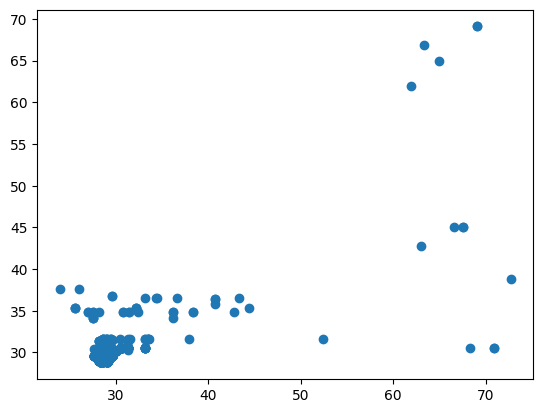

In [44]:
result_pd = predictions.select("prediction", "merchant_fraud").toPandas()
plt.scatter(result_pd.merchant_fraud, result_pd.prediction)

### Imputation for merchant fraud probability

In [45]:
imputation_data = impute_merchant_fraud_sdf.filter(F.col('merchant_fraud') == 0).drop('merchant_fraud')

In [46]:
imputed_sdf = model.transform(imputation_data)

In [47]:
imputed_sdf.select("prediction").describe()

summary,prediction
count,13610672
mean,35.32639052630379
stddev,10.384028596608651
min,28.79422838800745
max,69.09531723361195


We merge imputed merchant fraud probability to the main dataset.

In [48]:
# data with given merchant fraud probability
non_missing_merchant_fraud = model_sdf.select(["order_id", "merchant_fraud"])
imputed_sdf_select = imputed_sdf.select(["order_id", "prediction"]).withColumnRenamed("prediction", "merchant_fraud")

# Combine two dataset
full_merchant_fraud = imputed_sdf_select.union(non_missing_merchant_fraud)

In [49]:
# Save data to file
full_merchant_fraud.write.mode('overwrite').parquet('../data/curated/predicted_merchant_fraud/')

In [50]:
test = spark.read.parquet('../data/curated/predicted_merchant_fraud/')

In [51]:
test.count()

13614675

In [52]:
test.limit(5)

order_id,merchant_fraud
837c44b7-2b90-443...,51.72532419078493
5730b0b2-e109-4fd...,51.72532419078493
d8327836-ae0b-4b9...,51.72532419078493
41b152da-332b-4b4...,51.72532419078493
40a1701a-6d96-41c...,51.72532419078493
